In [178]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp
import qvalue as qv

<Figure size 1500x1000 with 0 Axes>

In [2]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)




In [3]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [4]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)
for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        full_df[f'Intclust {i} or not'] = full_df.apply(lambda row: i if (row['Integrative Cluster'] == i) else 'Not', axis = 1)


In [5]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import qvalue as qv

clusterframes = {}


for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        df_cluster = pd.DataFrame(index=pca_per_pathway.columns) 
        pvaluelist = []
        for pathway in df_cluster.index:
            results = ols("Q(pathway) ~ C(Q(f'Intclust {i} or not'))", data=full_df).fit()
            table = sm.stats.anova_lm(results, typ=2)
            pvalue = table['PR(>F)'][0]
            pvaluelist.append(pvalue)
    
        df_cluster['p-values'] = pvaluelist
        qv.qvalues(df_cluster, 'p-values', 'qvalues')
        print(i)
        clusterframes[i] = df_cluster

4ER+
9
7
3
8
10
1
2
5
4ER-
6


In [214]:
significant_pathways = {}
def failures_of_null_anova(cluster, my_xa, my_xb, iterations=10000):
    pvalues = clusterframes[cluster]['p-values'].tolist()
    pvalues = [0.999 if x == 1.0 else x for x in pvalues] ##pathways with p-val 1 gave error as range would be to inf
    z_scores = norm.ppf(pvalues)

    xa = np.percentile(z_scores, my_xa)
    xb = np.percentile(z_scores, my_xb)
    print(f'Quantiles calculated: {xa}, {xb}')


    trunc_z = z_scores[z_scores>xa]
    trunc_z = trunc_z[trunc_z<xb]

    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    loc_guess = np.median(z_scores)
    scale_guess = np.std(z_scores)
    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=iterations)
    print(par)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.hist(z_scores, bins=50, density=True)
    ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
    ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
    ax.plot(z_scores, (1-norm.cdf(abs(z_scores), par[2], par[3])), 'y-', lw=5, alpha=0.6, label='norm sf')
    ax.legend(loc='best')
    plt.show()

    p_vals = norm.sf(abs(z_scores), par[2], par[3])

    plt.figure(figsize=(15, 10))
    plt.hist(p_vals, bins=20, density=True)
    plt.show()
    #print(pvalues[:10])
    print(p_vals[:20])
    sig_pathways = p_vals[p_vals < 0.001].size
    significant_pathways[cluster] = sig_pathways
    print(f'number of pathways with p < 0.001: {p_vals[p_vals < 0.001].size}')
    
    
    
    ##let's add to clusterframes
    clusterframes[cluster]['adjusted p-value'] = p_vals
    qv.qvalues(clusterframes[cluster], 'adjusted p-value', 'adjusted q-values')
    
    ##and log fold change
    clusterframes[cluster]['log adjusted p-value'] = -np.log10(clusterframes[cluster]['adjusted p-value'])
    clusterframes[cluster]['log adjusted q-value'] = -np.log10(clusterframes[cluster]['adjusted q-values'])
    

Quantiles calculated: -4.361506569537295, 1.9888036311575497
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2764.284312468687
            Iterations: 102
            Function evaluations: 759
            Gradient evaluations: 102
[-1.29808574  1.60586884 -1.52287845  2.18678014]


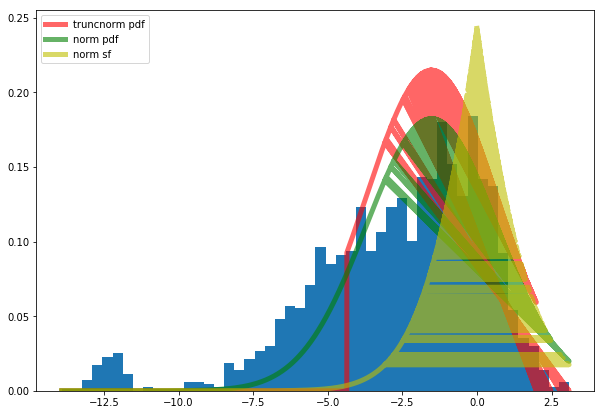

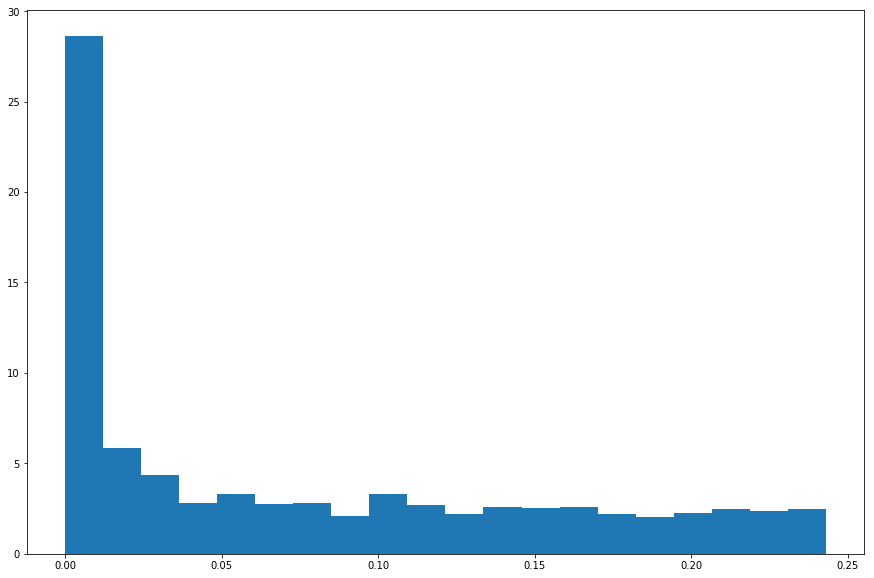

[8.42959063e-13 6.67859047e-12 9.25724603e-12 9.61448292e-12
 1.47097760e-11 1.47098015e-11 1.85202174e-11 2.22931910e-11
 2.78829187e-11 2.95935503e-11 3.41683751e-11 4.07514617e-11
 4.09891900e-11 4.15957570e-11 4.28703174e-11 4.38587699e-11
 5.40709617e-11 5.41148307e-11 5.41149119e-11 6.24565331e-11]
number of pathways with p < 0.001: 353


In [215]:
failures_of_null_anova('1', 25, 99)

In [181]:
clusterframes['1']

,p-values,qvalues,adjusted p-value,adjusted q-values
RMTs methylate histone arginines,2.678034e-44,5.554242e-41,8.429948e-13,1.748371e-09
HDMs demethylate histones,1.726380e-40,1.790256e-37,6.678853e-12,4.985302e-09
Senescence-Associated Secretory Phenotype (SASP),6.854062e-40,4.169670e-37,9.257605e-12,4.985302e-09
Cellular Senescence,8.041793e-40,4.169670e-37,9.614855e-12,4.985302e-09
Nucleosome assembly,4.833426e-39,1.670767e-36,1.471034e-11,5.084881e-09
...,...,...,...,...
Peptide ligand-binding receptors,4.982175e-01,6.081832e-01,2.424497e-01,2.427085e-01
Cap-dependent Translation Initiation,5.017138e-01,6.110125e-01,2.424743e-01,2.427085e-01
Eukaryotic Translation Initiation,5.017135e-01,6.110125e-01,2.424745e-01,2.427085e-01
Dual Incision in GG-NER,4.995643e-01,6.094684e-01,2.429325e-01,2.429663e-01


Quantiles calculated: -1.9487227015155724, 0.04665473470453199
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 711.2441938174895
            Iterations: 59
            Function evaluations: 416
            Gradient evaluations: 59
[-0.85760175  0.63311734 -0.80079403  1.3385335 ]


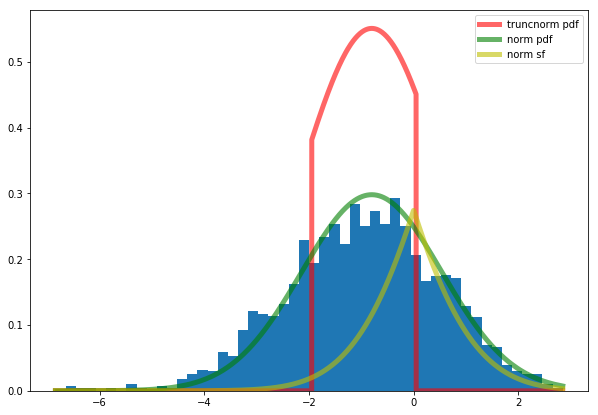

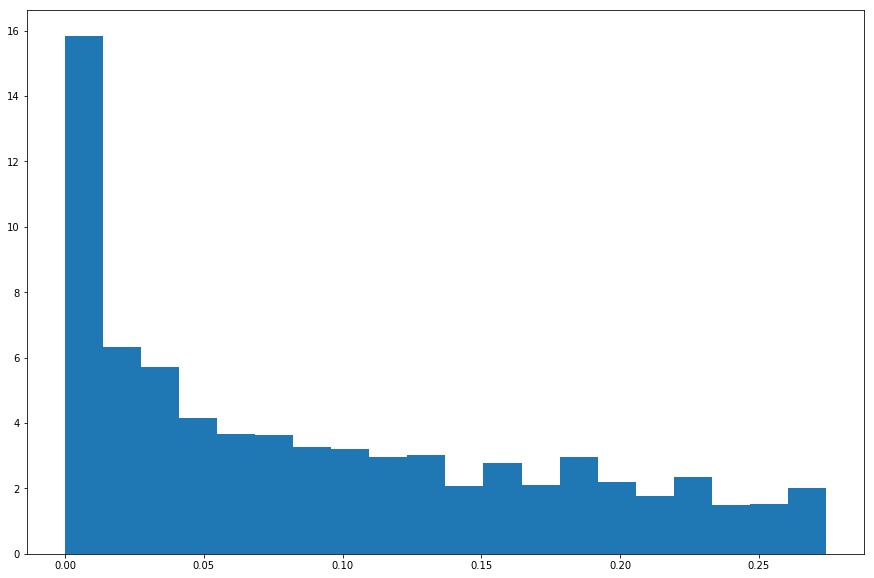

[5.54840800e-09 1.64753873e-08 1.78895361e-08 1.97728623e-08
 2.93855553e-08 5.08387878e-08 7.90279239e-08 1.14887875e-07
 3.10173365e-07 4.12181568e-07 1.38827278e-06 1.83111658e-06
 1.87768924e-06 1.94094975e-06 4.37453485e-06 4.37453896e-06
 7.78210073e-06 1.33112186e-05 1.33112683e-05 1.49333784e-05]
number of pathways with p < 0.001: 111


In [182]:
failures_of_null_anova('2', 25, 75)

Quantiles calculated: -2.96217311674425, 1.2101554070550111
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1344.0269269934145
            Iterations: 66
            Function evaluations: 482
            Gradient evaluations: 66
[-0.55444098  1.57971576 -1.87822746  1.95502441]


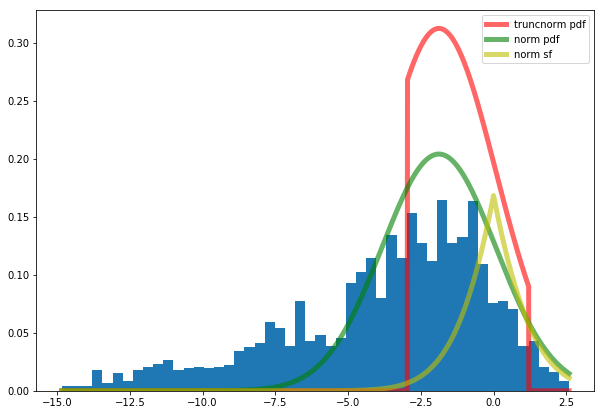

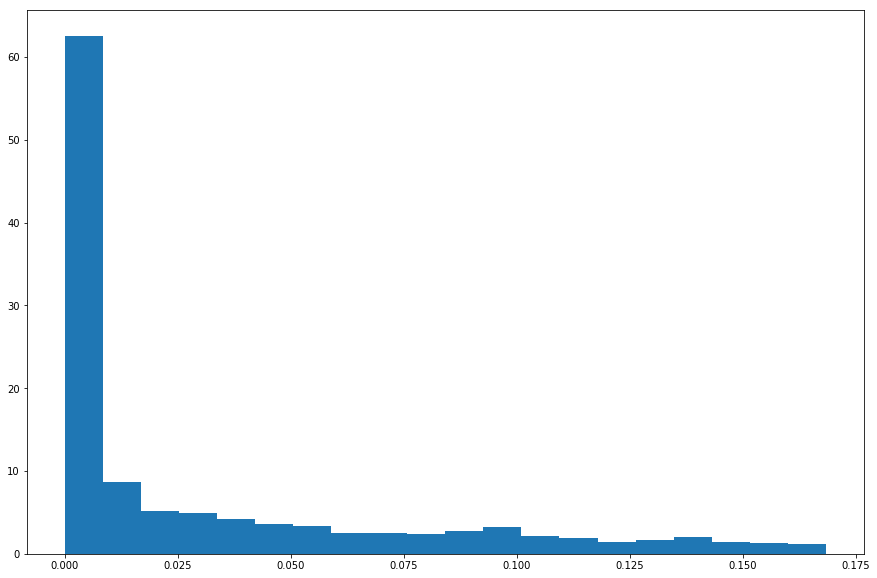

[6.12290710e-18 9.72227201e-18 1.26635299e-17 4.30988315e-17
 4.35416821e-17 5.84644438e-17 2.79320906e-16 3.51273749e-16
 3.51276295e-16 7.57634086e-16 7.84762804e-16 7.86742654e-16
 8.63671809e-16 9.05679321e-16 9.95361136e-16 1.05149739e-15
 1.33089633e-15 1.35599592e-15 1.37400184e-15 1.94302804e-15]
number of pathways with p < 0.001: 763


In [183]:
failures_of_null_anova('3', 50, 97, iterations=100000)

Quantiles calculated: -5.58050960122378, 0.9011314027328647
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2691.2327335375235
            Iterations: 54
            Function evaluations: 379
            Gradient evaluations: 54
[-1.17459668  0.85462222 -1.82866499  3.19415565]


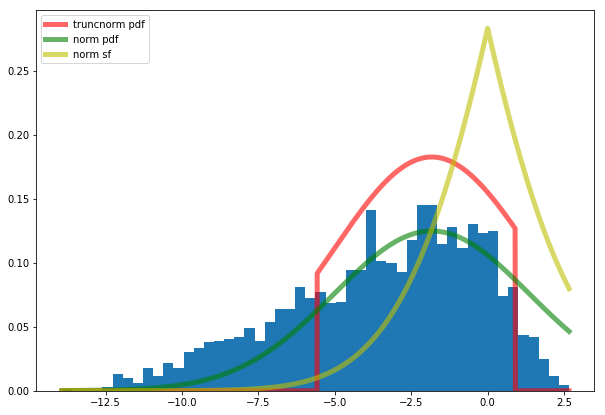

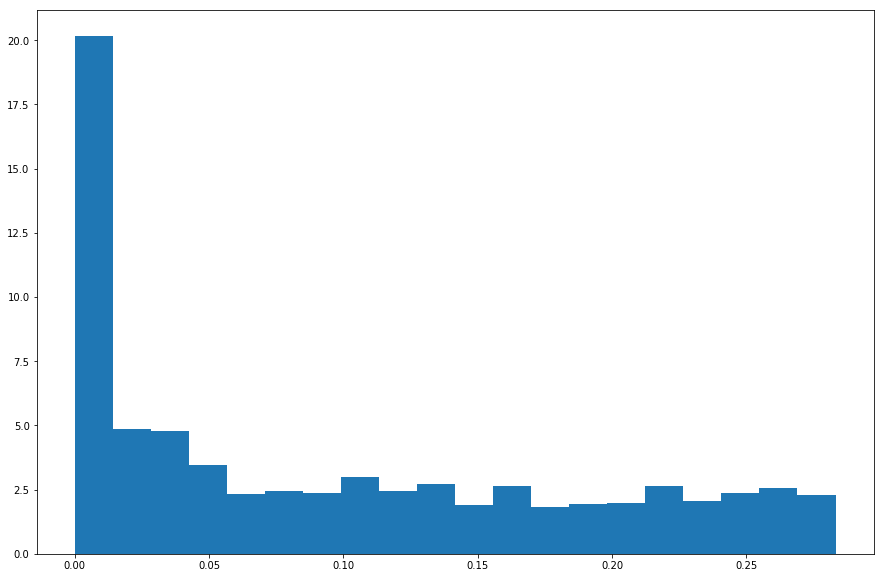

[4.03092513e-07 4.57358352e-06 5.02354106e-06 5.34783357e-06
 5.61610367e-06 5.62836813e-06 6.50112474e-06 6.56413675e-06
 7.45562457e-06 7.72816961e-06 7.80174987e-06 8.03050797e-06
 8.56508598e-06 8.71039286e-06 9.41911574e-06 1.03917156e-05
 1.17304557e-05 1.19953339e-05 1.21726022e-05 1.37399873e-05]
number of pathways with p < 0.001: 214


In [184]:
failures_of_null_anova('4ER-', 25, 95)

Quantiles calculated: -8.899909802300266, 1.369161947331994
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4011.2358597993
            Iterations: 79
            Function evaluations: 586
            Gradient evaluations: 79
[-1.36321677  1.14532715 -3.31939325  4.09363841]


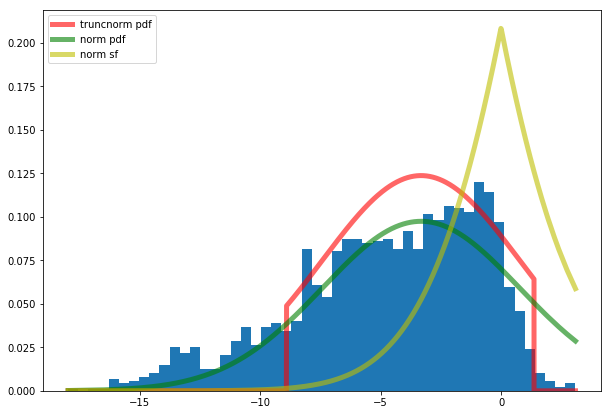

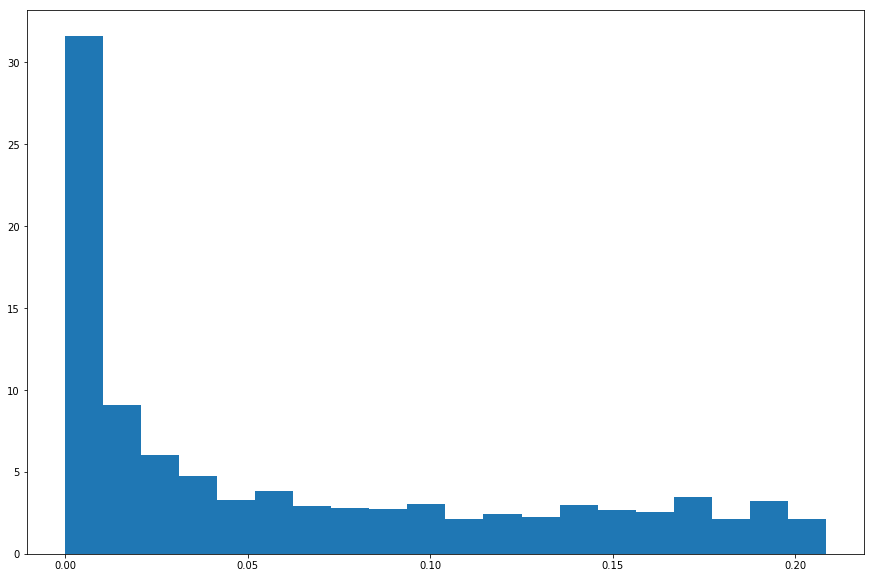

[1.00348620e-07 4.84587200e-07 6.66929961e-07 8.54234893e-07
 8.84587478e-07 8.85276968e-07 1.02007713e-06 1.13410773e-06
 1.14415824e-06 1.40765243e-06 1.59258131e-06 1.73102561e-06
 1.85306322e-06 2.40531729e-06 2.97078239e-06 2.98868311e-06
 3.29198122e-06 3.40992866e-06 4.13956864e-06 4.64917934e-06]
number of pathways with p < 0.001: 284


In [185]:
failures_of_null_anova('4ER+', 15, 99)

Quantiles calculated: -4.044030055788897, 1.7418364317210873
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2580.0126360510335
            Iterations: 134
            Function evaluations: 1016
            Gradient evaluations: 134
[-1.42688477  1.8498336  -1.52450783  1.76575031]


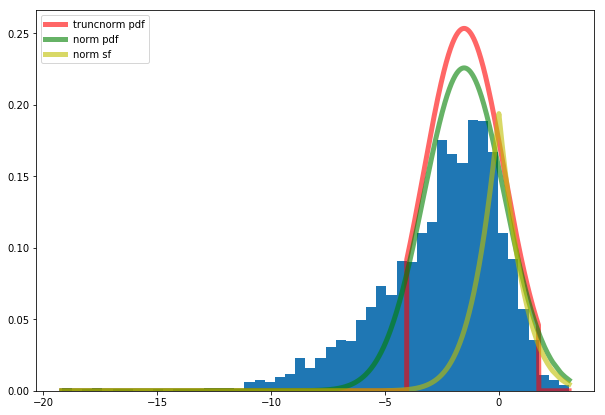

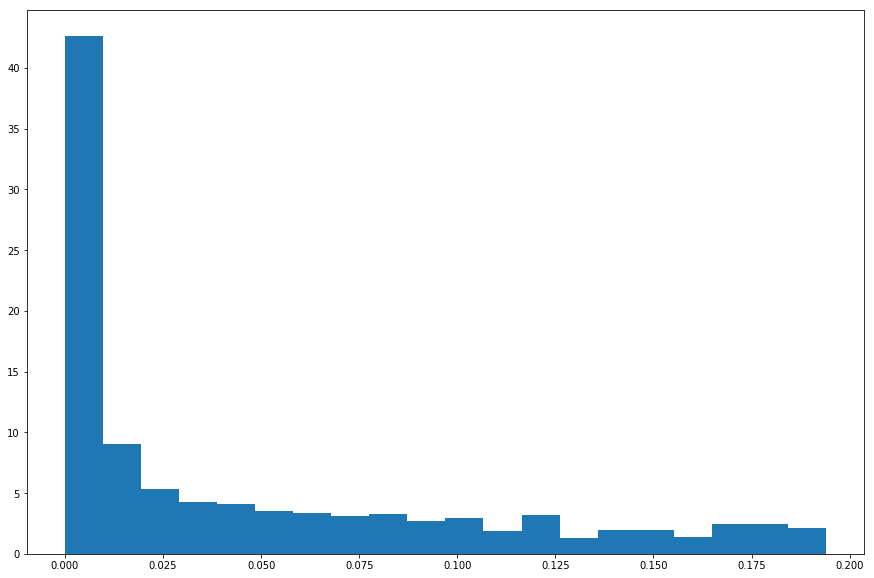

[4.89318689e-32 1.90125636e-31 2.06578398e-29 3.47820465e-27
 4.03424357e-27 1.18932765e-25 9.21637960e-24 7.78773096e-21
 1.84863468e-19 1.47075749e-17 1.10571018e-16 1.63147110e-16
 2.10660977e-16 1.54648673e-15 1.79040684e-15 1.44980254e-14
 3.34921248e-14 5.72404573e-14 3.57854021e-13 1.06288784e-12]
number of pathways with p < 0.001: 544


In [186]:
failures_of_null_anova('5', 25, 99)

Quantiles calculated: -5.564399174467789, 3.2169493454828544
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3917.678935674163
            Iterations: 88
            Function evaluations: 686
            Gradient evaluations: 88
[-2.42487962  2.66755737 -1.38296049  1.72439021]


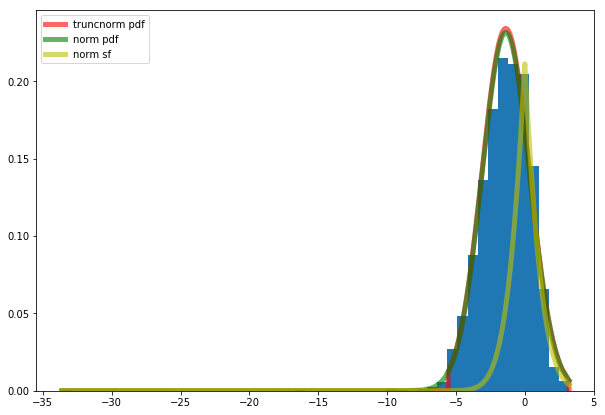

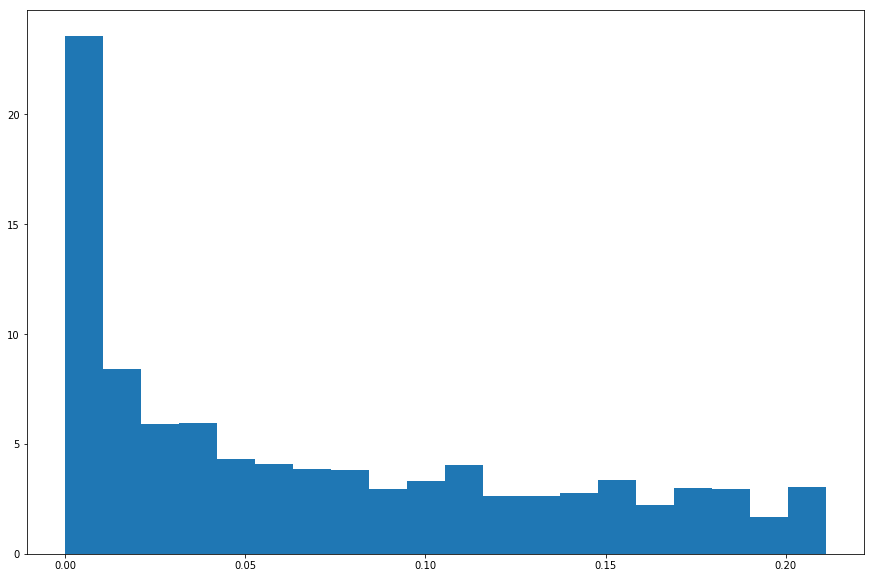

[6.40518316e-92 2.88270614e-25 4.92846026e-11 1.40658224e-10
 1.87727137e-09 1.23144524e-07 1.64134161e-07 7.14300642e-07
 7.49313436e-07 8.29026804e-07 2.14140384e-06 7.54478193e-06
 7.80874661e-06 1.35743490e-05 1.46721913e-05 1.51764214e-05
 1.59301780e-05 1.69866400e-05 1.84719264e-05 2.41521345e-05]
number of pathways with p < 0.001: 177


In [187]:
failures_of_null_anova('6', 1, 99.9)

Quantiles calculated: -10.494836842487489, 1.715223937628977
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4861.527993610182
            Iterations: 27
            Function evaluations: 187
            Gradient evaluations: 27
[-2.0942173   1.60566726 -3.58366973  3.30011939]


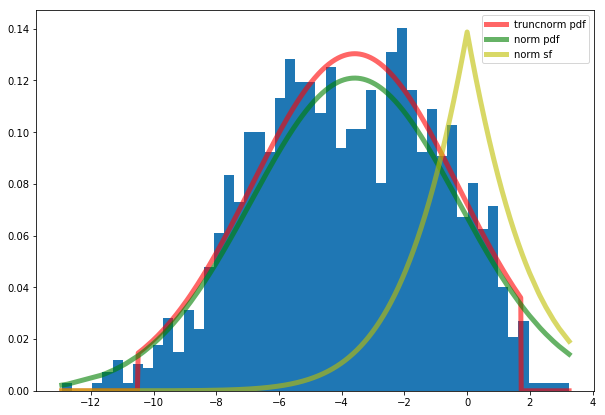

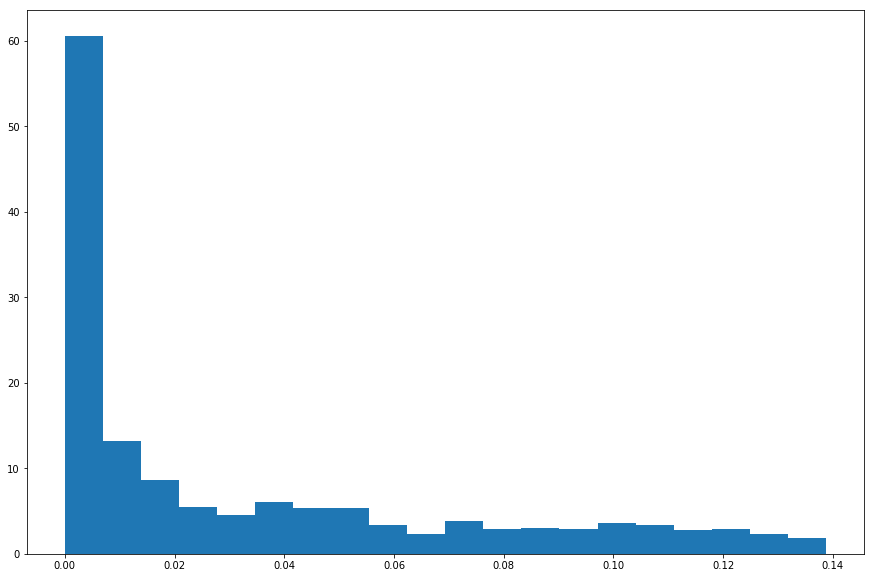

[2.83332960e-07 3.79347323e-07 1.88374729e-06 1.91300675e-06
 2.03522713e-06 2.07091312e-06 2.29098572e-06 2.38750537e-06
 3.12966645e-06 3.29373667e-06 3.29488764e-06 3.55597842e-06
 3.75912520e-06 3.76343945e-06 4.31965918e-06 4.67383047e-06
 4.77811943e-06 5.66470018e-06 5.83315483e-06 9.27105854e-06]
number of pathways with p < 0.001: 386


In [188]:
failures_of_null_anova('7', 1, 99, iterations=100000)

Quantiles calculated: -9.14894490361195, 2.6391844998202827
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3988.4818739808547
            Iterations: 26
            Function evaluations: 184
            Gradient evaluations: 26
[-1.25596966  1.7439451  -4.21362706  3.92948811]


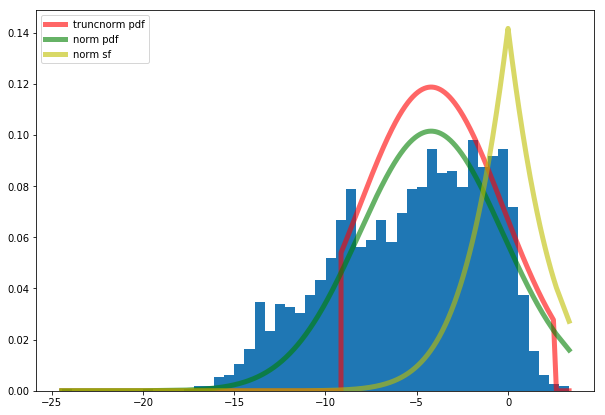

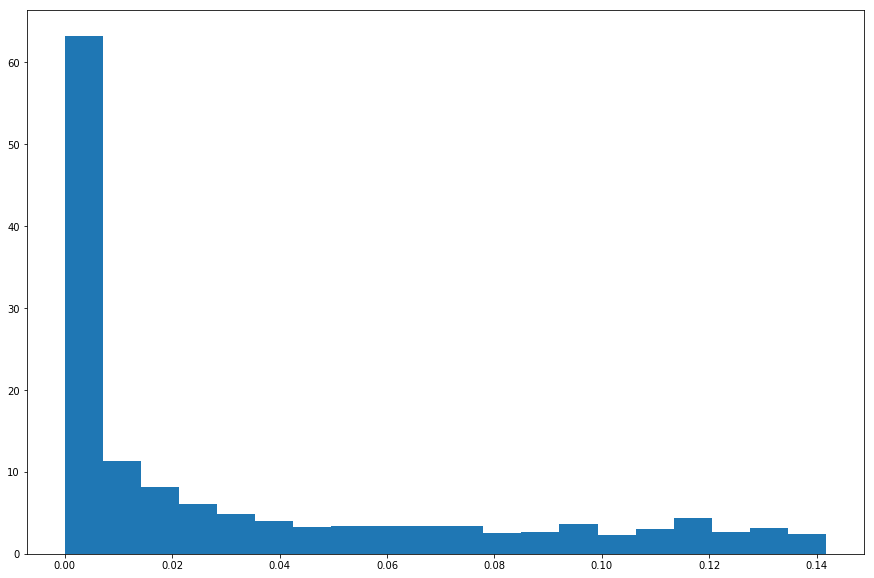

[1.50733443e-13 3.84407600e-10 1.36578744e-08 3.54900485e-08
 5.19091872e-08 9.03125566e-08 9.16324727e-08 1.29653545e-07
 1.51702461e-07 1.92713095e-07 1.95832668e-07 1.99519342e-07
 2.16689543e-07 2.59157343e-07 3.17788870e-07 3.28557141e-07
 3.75036320e-07 4.37069125e-07 4.56597319e-07 4.83805694e-07]
number of pathways with p < 0.001: 597


In [189]:
failures_of_null_anova('8', 20, 99.9)

Quantiles calculated: -3.747773078817006, -0.16806949015924408
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1435.5799718238359
            Iterations: 104
            Function evaluations: 738
            Gradient evaluations: 104
[-1.19810493  0.65101708 -1.42836934  1.93589366]


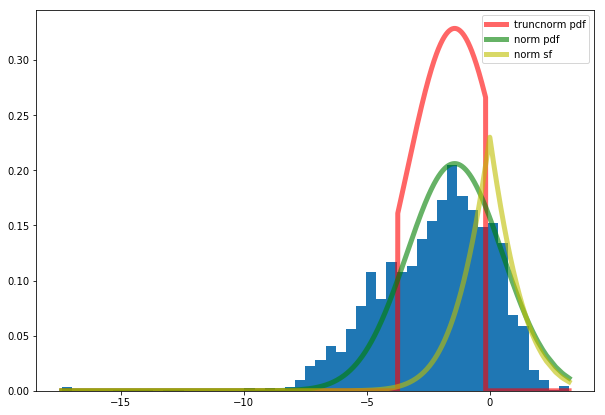

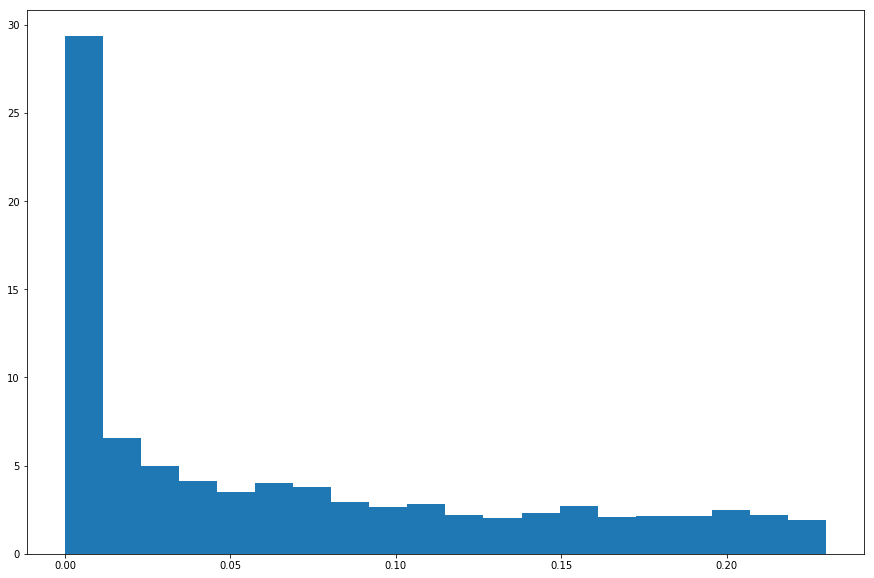

[1.15403282e-22 4.42091425e-22 4.42174078e-22 7.86976600e-18
 3.20215966e-17 3.36006038e-16 6.81568464e-16 4.27835647e-14
 7.78868169e-14 2.72140940e-09 3.48660023e-09 2.23307795e-08
 2.75739677e-08 3.24896999e-08 1.35898984e-07 3.51057073e-07
 5.91708617e-07 6.91378905e-07 7.41844760e-07 7.74114519e-07]
number of pathways with p < 0.001: 354


In [190]:
failures_of_null_anova('9', 25, 80)

Quantiles calculated: -13.943679011030461, 2.2799286911473513
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4296.722757710517
            Iterations: 27
            Function evaluations: 184
            Gradient evaluations: 27
[-1.13582068  1.17224501 -5.95989016  7.02909271]


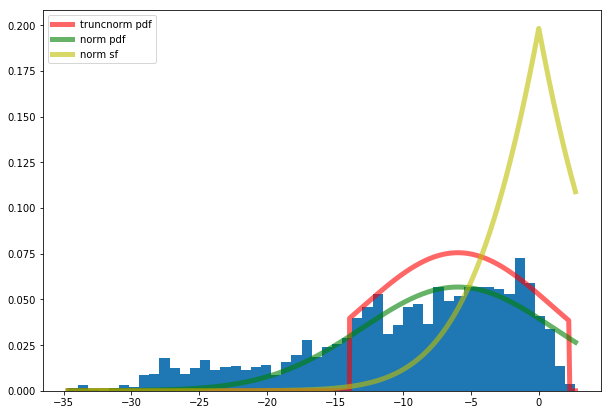

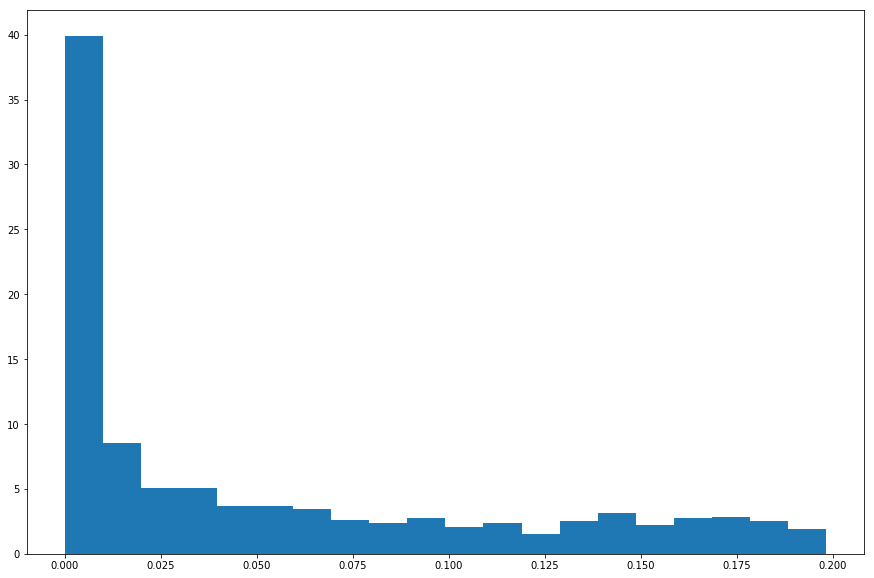

[3.75197225e-09 3.75197845e-09 1.15654347e-08 1.15654606e-08
 1.15654684e-08 1.15654771e-08 1.15654896e-08 1.39595674e-08
 4.94853021e-08 5.45895810e-08 8.03735885e-08 1.00349069e-07
 1.15866337e-07 1.21873940e-07 1.34603781e-07 1.90202631e-07
 1.92380355e-07 2.27058028e-07 2.41852827e-07 2.66220817e-07]
number of pathways with p < 0.001: 419


In [191]:
failures_of_null_anova('10', 25, 99.9)

In [210]:
gsea_df = pd.read_csv('../exp/GSEA_qvalues.csv', index_col = 0)
gsea_df_counts = {}

for column in gsea_df.columns:
    columnshape = gsea_df[gsea_df[column] >= 3].shape[0]
    gsea_df_counts[column] = columnshape

adjusted_q_counts = {}
for cluster in clusterframes:
    columnshape = clusterframes[cluster][clusterframes[cluster]['adjusted q-values'] <= 0.001].shape[0]
    adjusted_q_counts[cluster] = columnshape
    
wall_df = pd.read_csv('../exp/pathway_qvalues.csv', index_col = 0)
wal_df = wall_df.loc[:, wall_df.columns.str.endswith('q-values')]
new_name = {}
for i in wal_df.columns:
    new_i = i.strip('Cluster q-values')
    new_name[i] = new_i
    
wal_df = wal_df.rename(columns =new_name)

wall_df_counts = {}
for column in wal_df.columns:
    columnshape = wal_df[wal_df[column] >= 3].shape[0]
    #print(columnshape)
    wall_df_counts[column] = columnshape

wall_df_counts['4ER-'] = wall_df_counts.pop('4ER')
wall_df_counts

{'1': 828,
 '10': 1615,
 '2': 78,
 '3': 1048,
 '4ER+': 1303,
 '5': 839,
 '6': 290,
 '7': 1126,
 '8': 1354,
 '9': 723,
 '4ER-': 1029}

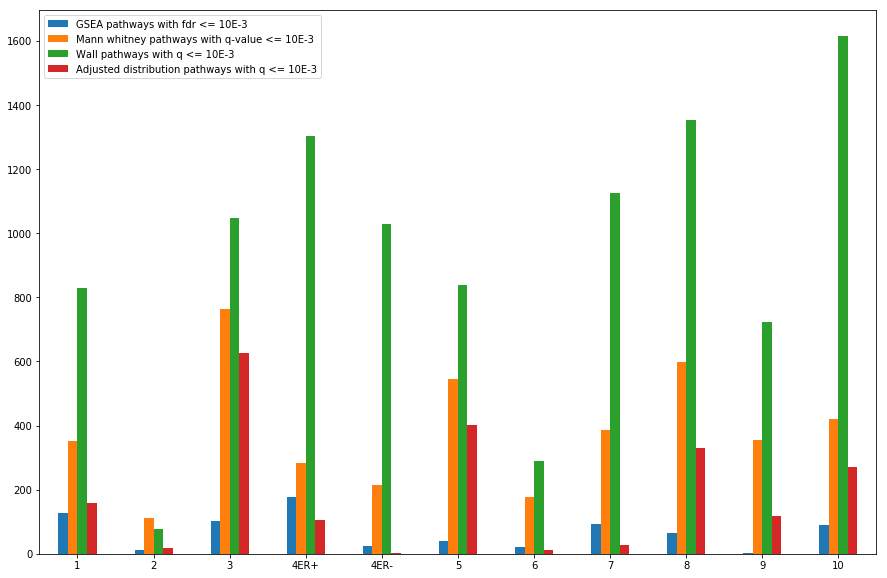

In [213]:
full_df = pd.DataFrame({'GSEA pathways with fdr <= 10E-3': gsea_df_counts, 
                        'Mann whitney pathways with q-value <= 10E-3': significant_pathways,
                        'Wall pathways with q <= 10E-3': wall_df_counts,
                        'Adjusted distribution pathways with q <= 10E-3': adjusted_q_counts})
ax = full_df.plot.bar(rot=0, figsize=(15, 10))
plt.show()